## Le modèle d’urnes d’Ehrenfest

In [ ]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.stats

### Modèle physique


Un système  mécanique est réversible: Quand une bille va d'un point A à un point B, on peut la faire revenir en arrière en inversant les vitesses initiales et les positions initiales. Le trajet de A vers B et celui de B vers A sont parfaitement symétriques.

Individuellement, les particules de gaz peuvent être considérées comme des billes. Mais le comportement d'un gaz dans son ensemble n'est pas du tout réversible: quand un gaz se met dans une position d'équilibre, il ne revient jamais  en arrière.   

Par exemple considérons un bocal séparé en deux par une paroi poreuse. A l'instant initial, on s'arrange pour qu'une moitié du bocal soit remplie d'air, et l'autre vide. Les particules vont alors diffuser à travers la paroi et au bout d'un certain temps, il y aura la même densité de particule dans les 2 parties du bocal. Mais le trajet inverse est impossible: jamais les particules ne reviendront spontanément dans une des deux moitiés.

Pour expliquer ce paradoxe, les physiciens Paul et Tatiana Ehrenfest ont introduit un modèle d’urnes qui porte leur nom.
On considère deux urnes contenant $N$ boules. À l’instant initial, toutes les boules se trouvent dans l’une des urnes (l'urne $A$). À chaque unité de temps, on tire au hasard une des $N$ boules et on la change d’urne.


### Matrice de transition

On suppose les particules indiscernables. L’état du système à l'instant $t$ est  le
nombre de particules $Y_t$ dans l'urne  $A$. L'espace d'état est donc  $E=\{0,1,....N\}$.
 La matrice de transition est donnée par:
\begin{align*}
P(x,x-1)&=\frac x N \\
P(x,x+1)&= \frac{N-x}{N}
\end{align*}
Cette chaine de Markov est récurrente:
elle revient indéfiniment à son état initial, mais l’espérance du temps de retour est si grande que ce
retour est physiquement inobservable quand $N$ est grand. En pratique, le système se rapproche très vite de l’équilibre, et semble ensuite osciller très peu autour de la position d’équilibre.

In [ ]:
class Ehrenfest:

    def __init__(self,N):

        self.states=np.arange(N+1)

        self.P = np.zeros([N+1,N+1])
        for x in range(1,N+1):
            self.P[x,x-1] = x/N
        for x in range(0,N):
            self.P[x,x+1] = (N-x)/N


    def simulate(self,x0,t_max):
        X = [x0]
        for _ in range(t_max):
            X.append(np.random.choice(a =self.states ,p = self.P[X[-1],:]))

        return np.array(X)

In [ ]:
simulator=Ehrenfest(10)
simulator.P

In [ ]:
fig,ax=plt.subplots(figsize=(10,3))
for _ in range(4):
    X=simulator.simulate(10,60)
    ax.plot(X,".-")

### Simulation sans la matrice

#### ♡♡

Le stockage de la matrice de transition, pleine de zéro est inutile. Effectuons cette même simulation sans stocké $P$. Du coup une fonction suffirait (les classes sont faite pour stocker des attributs).

Cependant on a envie de garder la même "interface" (API). Du coup on fait quand même un classe.  

In [ ]:
class Ehrenfest_noP:

    def __init__(self,N):
        self.N=N


    def simulate(self,x0,t_max):


In [ ]:
simulator=Ehrenfest_noP(10)

In [ ]:
fig,ax=plt.subplots(figsize=(10,3))
for _ in range(4):
    X=simulator.simulate(10,60)
    ax.plot(X,".-")

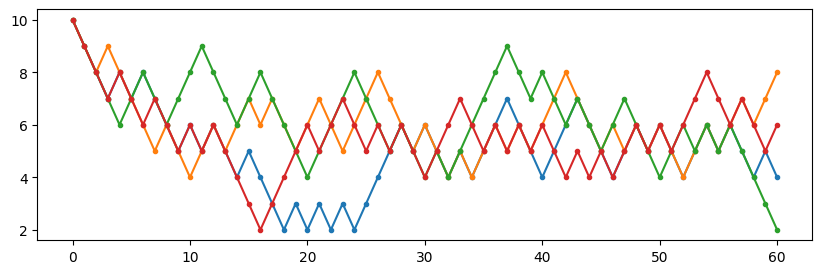

In [ ]:
#--- To keep following outputs, do not run this cell! ---

### Proba invariante

Comme cette chaîne de Markov est irréductible, elle possède une et une seule probabilité invariante.


> ***Proposition:*** La proba invariante est la loi binomiale de paramètres $N$ et $0.5$, c'est-à-dire la loi donnée par
$$
\pi = \left( \binom{N}{j}\times 0.5^N\right)_{0 \leq j \leq N},
$$
 où les $\binom{N}{j} = \frac{ n! }{ j! (n-j)!}$ désignent les coefficients binomiaux.


*Démonstration:* En notant $P$ la matrice de transition, on a:
\begin{align*}
(\pi P)(j) &=
\sum_{i=0}^N \pi (i) P(i,j)\\&=
\left(\binom{N}{j+1} \frac{j+1}{N} + \binom{N}{j-1} \frac{N - (j-1)}{N}\right) \times 0.5^N \\&=
\left(\binom{N-1}{j} + \binom{N-1}{j-1}\right) \times 0.5^N \\&=
\binom{N}{j} \times 0.5^N \\&=
\pi(j)
\end{align*}
$\square$



Cependant, la loi de $Y_N$ peut ne pas converger vers $\pi$. En effet, le théorème de convergence en loi ne s'applique pas sur cette chaîne de Markov car elle est périodique (de période 2). Cependant, quand le nombre de particules est grand, les petites fluctuations en loi provoquées par la périodicité sont invisibles sur les histogrammes des simulations (cf. plus bas).


### Temps de retours

On démontre que l’espérance du temps de retour en $x_o$ est l’inverse de $\pi(x_o)$.



L'espérance du temps de retour en $x_0$ est $\frac{1}{\pi(x_0)} = \frac{1}{\binom{N}{x_0} \times 0.5^N}$. On peut vérifier cela empiriquement :

In [ ]:
def retour_erhenfest(N,x0):
    max_it = 50000
    # On part de x0
    T = 0
    Y = x0
    # On fait un pas pour entrer dans le while qui suit
    Y = Y + np.random.choice(a=[-1,+1], p=[Y/N, 1-Y/N])
    T += 1
    # On avance jusqu'à retomber sur x0
    while ( Y != x0 and T < max_it ):
        Y = Y + np.random.choice(a=[-1,+1], p=[Y/N, 1-Y/N])
        T += 1
    if T == max_it:
        print("Nombre max d'itérations atteint, T non valide")
    return T

In [ ]:
N = 10
x0 = 0
print("Temps de retour en", x0, "avec N =", N)

m = 1000
s = 0
for _ in range(m):
    s += retour_erhenfest(N,x0)
print("Valeur empirique :", s / m)

print("Valeur théorique :", 1/scipy.stats.binom.pmf(x0,N,0.5))

Avec des vraies particules, dans une urne d'un litre, on a $N=6\cdot10^{23}$ (nombre d'Avogadro). On vous déconseille de tester le programme précédent avec ce $N$ là.

## Le modèle de Wright-Fisher

### Description

Une population de taille constante $N$ évolue  au cours du temps. Les individus
sont de deux types, $A$ et $B$.



Chaque individu de la  génération $t+1$ a un unique parent tiré au sort
 parmi les $N$ individus de la génération $t$ et hérite du type de son unique parent.


Notons $X_t$ le nombre d'individu  de la génération $t$.

> ***Proposition:*** $X_t$ est une chaine de Markov, de probabilité de transition
$$
P(i,j)= \binom{N}{j} \Big( \frac i N \Big)^j \Big( \frac {N-i} N \Big)^{N-j}
$$



#### ♡♡

Démontrez cette proposition. En fait, il c'est plus une "explication" qu'une "démonstration" qu'il faut dans ce cas précis.

#### ♡


Les deux états $\color{red}{\square \square \square}$ et $\color{red}{\square \square \square}$ sont absorbants pour cette chaîne de Markov, et les autres états communiquent tous entre eux. Il en résulte que $X_t$ converge <font color="red"> □ □ □ </font>.


### Simulation

In [ ]:
class WrightFisher:

    def __init__(self,N):

        self.P = np.zeros([N+1,N+1])
        self.states=np.arange(N+1)
        for i in range(N+1):
            self.P[i,:] = scipy.stats.binom(n=N,p=i/N).pmf(self.states)


    def simulate(self,x0,t_max):
        X = [x0]
        for _ in range(t_max):
            X.append(np.random.choice(a =self.states ,p = self.P[X[-1],:]))

        return np.array(X)

In [ ]:
simulator=WrightFisher(15)
simulator.P.shape

In [ ]:
fig,ax=plt.subplots(figsize=(10,4))
for _ in range(5):
    ax.plot(simulator.simulate(6,50),".-")

#### ♡♡♡

Modifiez ce programme pour qu'il ne simule les trajectoires jusqu'au temps d'absorbtion.

In [ ]:
class WrightFisherUntilAbsorbtion:

    def __init__(self,N):
        self.N=N
        self.P = np.zeros([N+1,N+1])
        self.states=np.arange(N+1)
        for i in range(N+1):
            self.P[i,:] = scipy.stats.binom(n=N,p=i/N).pmf(self.states)


    def simulate(self,x0):


In [ ]:
simulator=WrightFisherUntilAbsorbtion(10)
fig,ax=plt.subplots(figsize=(10,4))
for _ in range(5):
    ax.plot(simulator.simulate(6),".-")

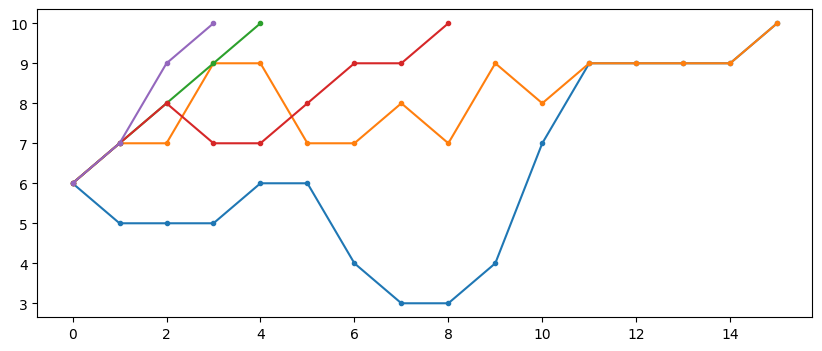

In [ ]:
#--- To keep following outputs, do not run this cell! ---

### Proba de finir avec que des $A$

> ***Théorème:***
$$
\mathbf P_i[X_\infty=N] = \frac i N
$$

*Démonstration:* Notons $\gamma_N$ le vecteur défini par
$$
\gamma_N(i) = \mathbf P_i[X_\infty=N]
$$
Il satisfait
$$
P \gamma_N = \gamma_N
$$
(on a déjà fait cette démonstration pour la marche aléatoire absorbée, c'est idem). C'est donc un vecteur propre de l'espace propre de $P$ associé à la valeur propre 1. Cette espace propre est de dimension 2 (car il y a 2 points absorbants). Déterminons cet espace propre. Le vecteur constant est un vecteur propre (car $P$ est une matrice stochastique). Et de plus:

> ***Lemme:*** Le vecteur $v(i)=i$ est  un  vecteur propre.

On démontrera ceci plus loin. Ainsi $\gamma_N$ s'écrit $\gamma_N(i) = \alpha + \beta i$. Mais par ailleurs il vérifie $\gamma_N(0) = 0$ et $\gamma_N(N) = 1$. On en déduit le résultat.


#### ♡♡

Démontrez le lemme: il n'y a quasi-aucun calcul à faire: Ecrivez ce qu'il faut démontrer, puis utilisez simplement ce que vous savez sur la loi binomiale.

#### ♡♡


Notons
$$
\gamma_0(i) = \mathbf P_i[X_\infty=0]
$$
Ce vecteur est-il aussi un vecteur invariant? Que vaut-il?

### Vérification empirique


Nous allons vérifier le théorème avec la technique de Monte-Carlo

#### ♡♡♡

In [ ]:
class WrightFisherEnd:

    def __init__(self,N):
        self.N=N
        self.P = np.zeros([N+1,N+1])
        self.states=np.arange(N+1)
        for i in range(N+1):
            self.P[i,:] = scipy.stats.binom(n=N,p=i/N).pmf(self.states)


    def simulate(self,x0):
        #renvoie True si la chaine de Markov finie sa vie en N


In [ ]:
N=10
simulator=WrightFisherEnd(N)
n_simu=300
occurances=np.zeros(N+1)

for x0 in simulator.states:
    for _ in range(n_simu):
        at_N=simulator.simulate(x0)
        if at_N:
            occurances[x0]+=1


occurances

In [ ]:
#--- To keep following outputs, do not run this cell! ---

array([  0.,  22.,  65.,  94., 119., 156., 182., 203., 230., 270., 300.])

#### ♡♡♡

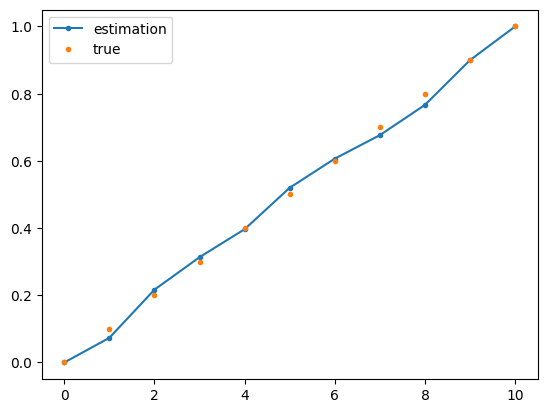

In [ ]:
#--- To keep following outputs, do not run this cell! ---

### Avec mutations

Supposons maintenant qu'avec une petite probabilité, un type $A$ puisse se transformer en type $B$ ou inversement.  

* Notons $\alpha$ la propa qu'un gène $A$ mute en $B$
* Notons $\beta$ la propa qu'un gène $B$ mute en $A$


#### ♡♡♡

Sachant $X_t=i$, la v.a $X_{t+1}$ suit toujours une loi binomiale, mais dont le paramètre est

$$
q_i = {i\over N} (1-\alpha) + \color{red}{\square \square \square}
$$
Pour justifier cette formule, un arbre de proba sera le bien venu.

#### ♡♡♡♡

Faites la simulation

In [ ]:
class WrightFisherMutation:
    ...


In [ ]:
simulator=WrightFisherMutation(10,0.05,0.05)
simulator.P.shape

In [ ]:
#--- To keep following outputs, do not run this cell! ---

(11, 11)

In [ ]:
fig,ax=plt.subplots(figsize=(10,4))
for _ in range(5):
    ax.plot(simulator.simulate(5,50),".-")

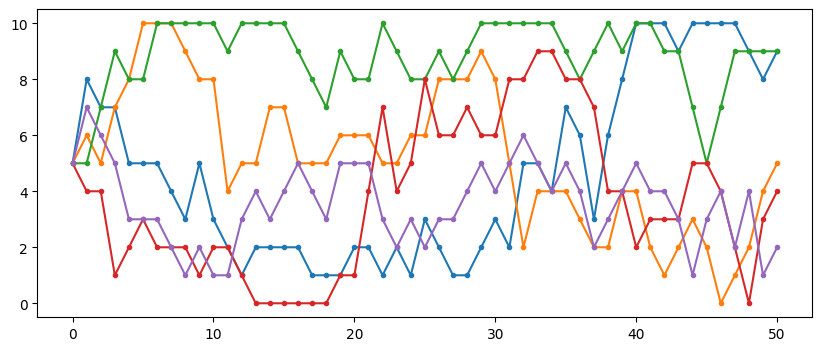

In [ ]:
#--- To keep following outputs, do not run this cell! ---